In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from simpledbf import Dbf5
# pip3 install simpledbf (included in environment.yaml)

PyTables is not installed. No support for HDF output.
SQLalchemy is not installed. No support for SQL output.


In [2]:
def weighting(distance = 1):

    resolution = 100;
    width = 0.5
    rng = range(-distance,distance+1)
    df = pd.DataFrame(index=rng, columns=rng)

    for x in rng:
        for y in rng:
            count = 0
            for xi in range(resolution):
                for yi in range(resolution):
                    dist = math.sqrt(((x-0.5)+(xi+0.5)/resolution)**2 + ((y-0.5)+(yi+0.5)/resolution)**2)
                    if (distance - width < dist) & (dist < distance + width):
                        count += 1 / (resolution**2)
            df.loc[x, y] = count
            
    return(df)

In [3]:
weights = weighting(3)

In [4]:
weights

,-3,-2,-1,0,1,2,3
-3,0,0.3518,0.8404,0.9884,0.8404,0.3518,0
-2,0.3518,0.8614,0.2307,0.0166,0.2307,0.8614,0.3518
-1,0.8404,0.2307,0,0,0,0.2307,0.8404
0,0.9884,0.0166,0,0,0,0.0166,0.9884
1,0.8404,0.2307,0,0,0,0.2307,0.8404
2,0.3518,0.8614,0.2307,0.0166,0.2307,0.8614,0.3518
3,0,0.3518,0.8404,0.9884,0.8404,0.3518,0


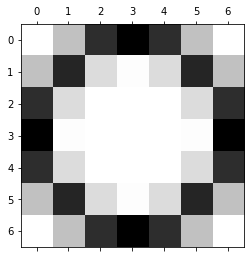

In [5]:
cmap=plt.get_cmap('Greys')
plt.matshow(weights.astype(float), cmap = cmap)

# Read and prepare data

In [6]:
# Read and display size + head
dbf = Dbf5('../data/JRC_POPULATION_2018.dbf')
df_raw = dbf.to_dataframe()
print(df_raw.size)
df_raw.head(10)

21749679


,OBJECTID,GRD_ID,CNTR_ID,TOT_P_2018,Country,Date,Method,Shape_Leng,Shape_Area
0,1,CRS3035RES1000mN1000000E1966000,ES,103,ES,2018-01-01,Aggregation from fine grid cells,4000.0,1000000.0
1,2,CRS3035RES1000mN1000000E1967000,ES,0,NaN,NaN,NaN,4000.0,1000000.0
2,3,CRS3035RES1000mN1000000E1979000,ES,0,NaN,NaN,NaN,4000.0,1000000.0
3,4,CRS3035RES1000mN1000000E1980000,ES,276,ES,2018-01-01,Aggregation from fine grid cells,4000.0,1000000.0
4,5,CRS3035RES1000mN1000000E1981000,ES,1693,ES,2018-01-01,Aggregation from fine grid cells,4000.0,1000000.0
5,6,CRS3035RES1000mN1000000E1982000,ES,89,ES,2018-01-01,Aggregation from fine grid cells,4000.0,1000000.0
6,7,CRS3035RES1000mN1001000E1966000,ES,0,NaN,NaN,NaN,4000.0,1000000.0
7,8,CRS3035RES1000mN1001000E1973000,ES,0,NaN,NaN,NaN,4000.0,1000000.0
8,9,CRS3035RES1000mN1001000E1980000,ES,0,NaN,NaN,NaN,4000.0,1000000.0
9,10,CRS3035RES1000mN1001000E1981000,ES,7608,ES,2018-01-01,Aggregation from fine grid cells,4000.0,1000000.0


In [7]:
# Every grid ID is unique:
df_raw.groupby('GRD_ID')['OBJECTID'].count().sort_values()

GRD_ID
CRS3035RES1000mN1000000E1966000    1
CRS3035RES1000mN3283000E3365000    1
CRS3035RES1000mN3283000E3366000    1
CRS3035RES1000mN3283000E3406000    1
CRS3035RES1000mN3283000E3407000    1
                                  ..
CRS3035RES1000mN2619000E4227000    1
CRS3035RES1000mN2619000E4228000    1
CRS3035RES1000mN2619000E4230000    1
CRS3035RES1000mN2619000E4147000    1
CRS3035RES1000mN999000E1983000     1
Name: OBJECTID, Length: 2416631, dtype: int64

In [8]:
# Encode GRD_ID + select Population und Country
df = df_raw.copy()
df[['N', 'E']] = df["GRD_ID"].str.split("N", n = 1, expand = True)[1].str.split("E", n = 1, expand = True).astype(int)
df = df.set_index(['N', 'E'])
df = df[['TOT_P_2018', 'CNTR_ID']]
df.columns = ['Population', 'Country']
df.head()

Population Country
N       E                          
1000000 1966000         103      ES
        1967000           0      ES
        1979000           0      ES
        1980000         276      ES
        1981000        1693      ES

In [9]:
# Focus on Germany first
df = df[df['Country']=='DE']

In [10]:
# Double-check overall poluation
df['Population'].sum()/1000000

81.596615

# Visualization

In [19]:
colors = df.copy()
colors['color'] = 'lightgray'
colors.loc[colors['Population'] > 0,'color'] = 'darkgreen'
colors.loc[colors['Population'] > 50,'color'] = 'yellowgreen'
colors.loc[colors['Population'] > 100,'color'] = 'orange'
colors.loc[colors['Population'] > 500,'color'] = 'red'
colors.head()

Population Country      color
N       E                                     
2689000 4341000           7      DE  darkgreen
2690000 4341000           3      DE  darkgreen
2691000 4340000           3      DE  darkgreen
        4341000          22      DE  darkgreen
2692000 4340000           0      DE  lightgray

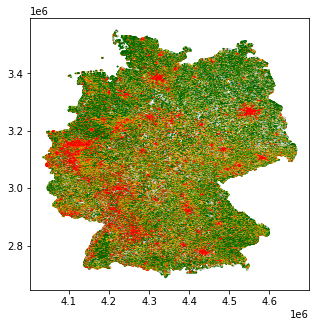

In [18]:
fig = plt.figure(figsize = [5,5])
plt.scatter(colors.index.get_level_values('E'), colors.index.get_level_values('N'), s = 0.4, c = colors['color'])

# Alternative way of plotting (requires slightly adjusted data format)
#cmap=plt.get_cmap('Greys')
#plt.matshow(test.astype(float), cmap = cmap)

# Calculating number of households near a raster field  

In [20]:
test = pd.DataFrame(
    data = np.ones([5,5]),
    index = ['a','b','c','d','e'], 
    columns = [1,2,3,4,5]
)

test.loc['a',1] = 10
test

,1,2,3,4,5
a,10.0,1.0,1.0,1.0,1.0
b,1.0,1.0,1.0,1.0,1.0
c,1.0,1.0,1.0,1.0,1.0
d,1.0,1.0,1.0,1.0,1.0
e,1.0,1.0,1.0,1.0,1.0


In [21]:
test

,1,2,3,4,5
a,10.0,1.0,1.0,1.0,1.0
b,1.0,1.0,1.0,1.0,1.0
c,1.0,1.0,1.0,1.0,1.0
d,1.0,1.0,1.0,1.0,1.0
e,1.0,1.0,1.0,1.0,1.0


In [22]:
def shift_from(y, x, df):
    
    def from_x(x, df):
        if x < 0:
            return(df.columns[:x])
        else:
            return(df.columns[x:])
    
    def from_y(y, df):
        if y < 0:
            return(df.index[:y])
        else:
            return(df.index[y:])

    return(df.loc[from_y(y, df), from_x(x, df)])

def to_x(x, df):
    if x <= 0:
        return(df.columns[-x:])
    else:
        return(df.columns[:-x])
    
def to_y(y, df):
    if y <= 0:
        return(df.index[-y:])
    else:
        return(df.index[:-y])

In [23]:
def habitants_in_range(dfi, distance = 1):
    weights = weighting(distance)

    dfo = pd.DataFrame(0, index = dfi.index, columns = dfi.columns)

    for x in weights.columns:
        for y in weights.index:
            dfo.loc[to_y(y, dfo), to_x(x, dfo)] += shift_from(y, x, dfi).values * weights.loc[y, x]
    
    return(dfo)

In [24]:
range_1 = habitants_in_range(test, 1)
range_1

,1,2,3,4,5
a,4.6290,12.9664,4.2202,4.2202,2.7030
b,12.9664,11.1914,6.2828,6.2828,4.2202
c,4.2202,6.2828,6.2828,6.2828,4.2202
d,4.2202,6.2828,6.2828,6.2828,4.2202
e,2.7030,4.2202,4.2202,4.2202,2.7030
